In [1]:
import matplotlib.pyplot as plt
import hopsy
import os
import numpy as np
from scipy.optimize import fsolve
import pandas as pd
from scipy.optimize import curve_fit
from PolyRound.api import PolyRoundApi
import ot
from scipy import stats

Dieser Code ist folgendermaßen gegliedert.

    1) Bestimmung des Mittelwerts der Wachstumsrate und der empirischen Varianz basierend auf den Daten
    2.1) Bestimmung der Parameter für die Boltzmann-Verteilung
    2.2) Bestimmung des Fehlers, die wir bei der Bestimmung des Parameters der Boltzmann-Verteilung machen
    3) Bestimmung der Randdichten der Flüsse
    4) Bestimmung der Sensitivität
    4.1) Wassserstein-2-Distanz
    4.2) statistische Tests: Kolmogorov-Smirnov-Test (Randdichten), ggf. auch mit mehrdimensionalen Verteilungen, Vergleich der
         Erwartungswerte
    
    

1) Bestimmung des Mittelwertes der Wachstumsrate und der empirischen Varianz

0.0094969666209908


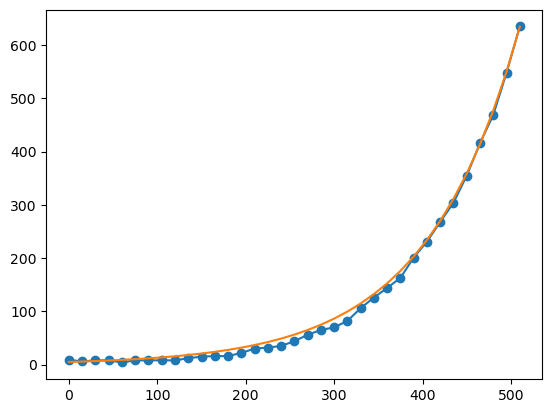

0.0094969666209908 9.813019352440935e-07


In [87]:
# Bestimme die Wachstumsrate (d.h. die Anzahl der neuen Zellen pro Minute durch
# exponentiellen Fit an die Daten)

with open("C:\\Users\\carol\OneDrive\\Desktop\\Juelich\\maxentflux\\growth_rate_ds.csv", newline='') as csvfile:
    # Erstellen Sie ein CSV-Leserobjekt
    csvreader = pd.read_csv(csvfile)

# Aufteilen der Daten
# Hier: Beispielhaft mit einem Medium
Acetate = csvreader[csvreader['medium'] == 'Acetate-MOPS']
Citrat = csvreader[csvreader['medium'] == 'Citrat-MOPS']
Gluconate = csvreader[csvreader['medium'] == 'Gluconate-MOPS']
PCA = csvreader[csvreader['medium'] == 'PCA-Gluc']
BHI = csvreader[csvreader['medium'] == 'BHI']
Fructose = csvreader[csvreader['medium'] == 'Fructose-MOPS']
Glucose = csvreader[csvreader['medium'] == 'Glucose-MOPS']
Pyruvate = csvreader[csvreader['medium'] == 'Pyruvate-MOPS']
# Daten für Regression
# Wichtig: Muss an das jeweilige Medium angepasst werden!
data = Glucose["cell_count"]
laenge_teilliste = max(Glucose["frame"])
# Daten für die Zeit erstellen
maximaler_wert = (laenge_teilliste + 1) * 15 

t = []

# Schleife, um Vielfache von 15 hinzuzufügen
for i in range(0, maximaler_wert, 15):
    t.append(i)

# Teillisten initialisieren
teillisten = []

# Schleife, um die Ausgangsliste in Teillisten aufzuteilen
def teile_liste(input_list, n):
    # Initialisiere eine leere Ergebnisliste
    output_list = []

    # Schleife, um die Eingabeliste in Teillisten aufzuteilen
    for i in range(0, len(input_list), n):
        teil_liste = input_list[i:i+n]
        output_list.append(teil_liste)

    return output_list

teillisten = teile_liste(data, laenge_teilliste + 1)
        
# Ansatz für die Regression
def exponential_growth(t, r):
    return c * np.exp(r * t)

# Epxonentieller Fit
mw = []

for i in teillisten:        
    c = i.tolist()[0]
    N = i.tolist()
    # Schätze Parameter c und r mit Regression
    params, covariance = curve_fit(exponential_growth, t, N, maxfev = 100000)
    # Extrahieren der geschätzten Parameter
    r_estimated = params
    mw.append(r_estimated)

# \bar{\lambda}
print(np.mean(mw))
bar_lambda = np.mean(mw)
# Varianz der Wachstumsrate
var_lambda = np.var(mw)

# Plotten
y_fit = []
for i in t:
    y_fit.append(5 * np.exp(bar_lambda * i))
plt.plot(t, teillisten[0], marker='o') 
plt.plot(t, y_fit)
plt.show()
# Wichtig: Hierbei ist die Einheit noch Minuten bzw. Minuten^2
print(bar_lambda, var_lambda)

2.1) Bestimme den Parameter der Boltzmann-Verteilung

In [92]:
model_path = os.path.join("C:/Users/carol/OneDrive/Desktop/Juelich", "iEZ481_Glc.xml")
polytope = PolyRoundApi.sbml_to_polytope(model_path)
problem = hopsy.Problem(polytope.A, polytope.b)

Model does not contain SBML fbc package information.
SBML package 'layout' not supported by cobrapy, information is not parsed
SBML package 'render' not supported by cobrapy, information is not parsed
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_h_c "h[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_h_e "h[e]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_atp_c "atp[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_glc_D_c "glc-D[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_adp_c "adp[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_g6p_c "g6p[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_f6p_c "f6p[c]">
Use of FORMULA in t

Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_C181ACP_c "C181ACP[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_AGL3P_c "AGL3P[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_pa_EC_c "pa-EC[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_cdpdag_EC_c "cdpdag-EC[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_cmp_c "cmp[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_pgp_EC_c "pgp-EC[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_ser_L_c "ser-L[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_ps_EC_c "ps-EC[c]">
Use of FORMULA in the notes element is discouraged, use fbc:ch

Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_3mob_c "3mob[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_ala_L_c "ala-L[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_ala_D_c "ala-D[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_alac_S_c "alac-S[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_23dhmb_c "23dhmb[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_4pasp_c "4pasp[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_aspsa_c "aspsa[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_23dhdp_c "23dhdp[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemical

Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_man1p_c "man1p[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_gdpman_c "gdpman[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_glyc_c "glyc[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_acgam1p_c "acgam1p[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_uacgam_c "uacgam[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_gam6p_c "gam6p[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_gam1p_c "gam1p[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_g1p_c "g1p[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFo

Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_lys_L_e "lys-L[e]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_cit_e "cit[e]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_leu_L_e "leu-L[e]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_tyr_L_e "tyr-L[e]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_trp_L_e "trp-L[e]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_pro_L_e "pro-L[e]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_ile_L_e "ile-L[e]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_met_L_e "met-L[e]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula 

Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_dann_c "dann[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_dtbt_c "dtbt[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_btn_c "btn[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_itn_c "itn[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_itn_e "itn[e]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_urea_e "urea[e]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_no3_e "no3[e]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_phe_L_e "phe-L[e]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species 

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_gapB "gapB">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_pgk "pgk">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_pgk "pgk">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_pgm "pgm">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_pgm "pgm">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_eno "eno">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_eno "eno">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_pyk "pyk">
Use of GENE ASSOCIATION or

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_tal "tal">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_tal "tal">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_tkt_2 "tkt_2">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_tkt_2 "tkt_2">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_cyto_bd_complex "cyto-bd-complex">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_cyto_bd_complex "cyto-bd-complex">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ATPase "ATPase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gp

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_purN "purN">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_purLQS "purLQS">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_purLQS "purLQS">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_purM "purM">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_purM "purM">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_purC "purC">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_purC "purC">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_purB_1 "purB_1">


Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_pyrF "pyrF">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_pyrD "pyrD">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_pyrD "pyrD">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_pyrE_2 "pyrE_2">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_pyrE_2 "pyrE_2">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_pyrC "pyrC">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_pyrC "pyrC">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_pyrB "pyrB">
Use 

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_asd "asd">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_dapA "dapA">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_dapA "dapA">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_dapB "dapB">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_dapB "dapB">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_dapD "dapD">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_dapD "dapD">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_dapC "dapC">
Use of GENE AS

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_proB "proB">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_proA "proA">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_proA "proA">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_proC "proC">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_proC "proC">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_rGLUGSAL "rGLUGSAL">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_rGLUGSAL "rGLUGSAL">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_serA "ser

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_hisB "hisB">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_hisC "hisC">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_hisC "hisC">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_hisN "hisN">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_hisN "hisN">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_hisD "hisD">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_hisD "hisD">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_r2_6_1_13 "r2_6_1_13">
Us

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_panB "panB">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_panE "panE">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_panE "panE">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_panD "panD">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_panD "panD">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_panC "panC">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_panC "panC">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ribA "ribA">
Use of GENE 

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_pmmB "pmmB">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_glgA "glgA">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_glgA "glgA">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_scrB "scrB">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_scrB "scrB">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_pfkB "pfkB">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_pfkB "pfkB">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_GLC_t_PEP "GLC_t_PEP">
Us

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ARBGALN_a "ARBGALN_a">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ARBGALN_a "ARBGALN_a">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_PTDGLYN_a "PTDGLYN_a">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_PTDGLYN_a "PTDGLYN_a">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_FMYCAC_a "FMYCAC_a">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_FMYCAC_a "FMYCAC_a">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_MYCAC_a "MYCAC_a">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discourag

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_nucA_8 "nucA_8">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_nucA_9 "nucA_9">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_nucA_9 "nucA_9">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_nucA_10 "nucA_10">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_nucA_10 "nucA_10">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ushA "ushA">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ushA "ushA">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_r

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_gntK "gntK">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_prpDBC "prpDBC">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_prpDBC "prpDBC">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ALA_D_deg "ALA-D_deg">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ALA_D_deg "ALA-D_deg">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_msmA "msmA">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_msmA "msmA">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_GLU_t_ATP "GLU_t_ATP">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_RIB_t_ATP "RIB_t_ATP">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_RIB_t_ATP "RIB_t_ATP">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_XYL_t_ATP "XYL_t_ATP">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_XYL_t_ATP "XYL_t_ATP">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_URA_t_ATP "URA_t_ATP">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_URA_t_ATP "URA_t_ATP">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discoura

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ETOH_d "ETOH_d">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ETOH_d "ETOH_d">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_LAC_L_t_H "LAC-L_t_H">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_LAC_L_t_H "LAC-L_t_H">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_GAL_d "GAL_d">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_GAL_d "GAL_d">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_GLYC_R_d "GLYC-R_d">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instea

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_EX_gln_L_e "EX_gln_L(e)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_EX_glu_L_e "EX_glu_L(e)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_EX_gly_e "EX_gly(e)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_EX_glyc_e "EX_glyc(e)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_EX_h2o_e "EX_h2o(e)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_EX_his_L_e "EX_his_L(e)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_EX_ile_L_e "EX_ile_L(e)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:flux

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_aecD_2 "aecD_2">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_aecD_2 "aecD_2">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_EX_pca "EX_pca">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_pcaK "pcaK">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_pcaK "pcaK">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_pcaGH "pcaGH">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_pcaGH "pcaGH">
Malformed gene_reaction_rule '(pcaG and pca H)' for (pcaG and pca H)
Traceback (most recent call last):
  File "C:\Users\ca

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_sdhCAB "sdhCAB">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_fumC "fumC">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_mdh "mdh">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_aceA "aceA">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_aceB "aceB">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_pckG "pckG">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ppc "ppc">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_pyc "pyc">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use f

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_tmk "tmk">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_thyA "thyA">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_dut "dut">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ndk_6 "ndk_6">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_dcd_2 "dcd_2">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ndk_5 "ndk_5">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ndk_11 "ndk_11">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_pyrE_1 "pyrE_1">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discou

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ilvD_ile "ilvD_ile">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_leuA "leuA">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_leuE "leuE">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_leuCD "leuCD">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ilvE "ilvE">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_leuB "leuB">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_leuP "leuP">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_proB "proB">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discou

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_r2_7_7_18 "r2_7_7_18">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_r3_5_1_19 "r3_5_1_19">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_r2_4_2_11 "r2_4_2_11">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_panB "panB">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_panE "panE">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_panD "panD">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_panC "panC">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ribA "ribA">
Encoding OBJECTIVE_COEFFICIENT in 

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_RNA_a "RNA_a">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ARBGALN_a "ARBGALN_a">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_PTDGLYN_a "PTDGLYN_a">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_FMYCAC_a "FMYCAC_a">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_MYCAC_a "MYCAC_a">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_PLIP_a "PLIP_a">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_cmt "cmt">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_cmt_3 "cmt_3">
Encoding OBJECTIVE_COEFF

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_msmA "msmA">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_gabT "gabT">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_gabD2 "gabD2">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_cysND "cysND">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_cysH_1 "cysH_1">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_cysC "cysC">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_cysH_2 "cysH_2">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_unk_34 "unk_34">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is 

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_LAC_D_t_H "LAC-D_t_H">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ASN_d "ASN_d">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ASP_d "ASP_d">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_GLY_d "GLY_d">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_CYS_d "CYS_d">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_HIS_d "HIS_d">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_PPI_d "PPI_d">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_PYR_d "PYR_d">
Encoding OBJECTIVE_COEFFICIENT in Kineti

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_EX_so3_e "EX_so3(e)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_EX_suc_e "EX_suc(e)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_EX_sucr_e "EX_sucr(e)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_EX_thr_L_e "EX_thr_L(e)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_EX_tre_e "EX_tre(e)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_EX_trp_L_e "EX_trp_L(e)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_EX_tyr_L_e "EX_tyr_L(e)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_

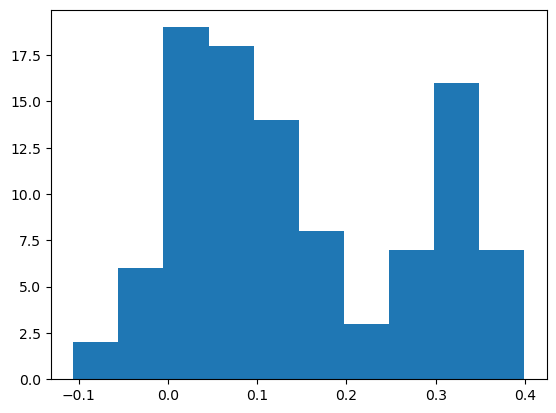

Der gefundene Wert für beta ist: -14.702514102732895


In [116]:
# Index der Biomasse
biomass_index = polytope.A.columns.tolist().index('biomass_a')

problem = hopsy.round(problem)

starting_point = hopsy.compute_chebyshev_center(problem)
# Gleichverteilte Samples
chains = [hopsy.MarkovChain(problem, starting_point = starting_point) for i in range(1)]

rng = [hopsy.RandomNumberGenerator(seed= i) for i in range(1)]

accrate_e_coli, samples = hopsy.sample(chains, rng, n_samples=100, thinning=10)


samples = samples[:,:,biomass_index][0]
# Histogramm anzeigen lassen
plt.hist(samples)
plt.show()

res_samples = []
# Ziel: Python kann die Werte wieder ausrechnen
for i in samples:
    res_samples.append(i)

# Bestimmung der zu lösenden Gleichung
# Wachstumsrate lambda(v) = v_24 (hier)
def lambda_function(v1, beta):
    res = 0
    res1 = 0
    for i in v1:
        res+= i * np.exp(i*beta)
        res1 += np.exp(i*beta)
    return res/res1 

# Definieren der Funktion, die das Integral berechnet - Abhängig von beta
def quad_integrand(beta):
    result = lambda_function(res_samples, beta)
    return result

# Definieren der Funktion, die integriert wird - Abhängig von beta
def equation_to_solve(beta, c):
    return c - quad_integrand(beta)


# Definiere Konstante c
# Hier die Wachstumsrate von den Zellen in einem bestimmten Medium
# Wichtig ist, dass diese Wachstumsrate grüßer als Null ist
# Kann problematisch werden bei sehr großen oder sehr kleinen Werten!
c =  bar_lambda

# Schätzen Sie einen Startwert für beta
# beta ist (hier) normalerweise negativ
initial_guess = 0

# Verwende fsolve, um die Gleichung zu lösen und den Wert für beta zu finden
result_beta = fsolve(equation_to_solve, initial_guess, args=(c,))

# Das Ergebnis enthält den gefundenen Wert für beta
print(f"Der gefundene Wert für beta ist: {result_beta[0]}")
beta = np.array(result_beta[0])

In [97]:
print(samples)

[-0.03265184 -0.04105493 -0.10609861 -0.04638698  0.08498953  0.08662998
 -0.01503609  0.09643242  0.03445371 -0.05742503 -0.0295197  -0.01036958
  0.01904758  0.03497778  0.07556155  0.04464894  0.03066206  0.00641592
  0.0367451   0.08265152  0.12380121  0.11189754  0.11202564  0.14186961
  0.22259433  0.29680846  0.1994259   0.33451392  0.38555499  0.32992841
  0.33869195  0.34996509  0.26279243  0.33967316  0.31400863  0.32543496
  0.32980839  0.36958797  0.33535102  0.32470758  0.31719837  0.3991006
  0.33108432  0.33962946  0.36397385  0.33320921  0.34749282  0.35842696
  0.34872583  0.33351192  0.31416261  0.27068645  0.2940281   0.26697357
  0.24395053  0.25447938  0.28078871  0.19693874  0.19497434  0.1748514
  0.16814846  0.16461409  0.16885594  0.16712701  0.15037614  0.1185845
  0.12173578  0.11398486  0.10600176  0.13564249  0.11350795  0.11012653
  0.03079522  0.02053885  0.01864699  0.03459581  0.03076037  0.04661051
  0.06131185  0.06113529  0.08370128  0.06907444  0.08

2.2) Fehlerbestimmung durch Näherung des Integrals

In [112]:
# Bestimmung der zu lösenden Gleichung
# Wachstumsrate lambda(v) = v (hier)
def lambda_function(v1, beta):
    res = 0
    res1 = 0
    for i in v1:
        res+= i * np.exp(i*beta)
        res1 += np.exp(i*beta)
    return res, res1 

# Definiere die verschiedenen Beta, für welche der relative MC-Fehler bestimmt werden soll
# Hier die Wachstumsrate von den Zellen in einem bestimmten Medium
# Kann problematisch werden bei sehr großen oder sehr kleinen Werten!
c =  np.linspace(-1,1,5) 

# Liste, in der der relative MC-Fehler steht
n = 2 # Anzahl der simulierten Integrale
var = []
for j in c:
    # Integral im Zähler
    result = []
    # Integral im Nenner
    result1 = []
    # Effekitve Samples Size
    ess = []
    for k in range(n):
        starting_point = hopsy.compute_chebyshev_center(problem)
        chains = [hopsy.MarkovChain(problem, starting_point = starting_point) for i in range(1)]
        rng = [hopsy.RandomNumberGenerator(seed= k) for i in range(1)]
        accrate, samples_uniform = hopsy.sample(chains, rng, n_samples=10, thinning=100)
        ess.append(min(min(hopsy.ess(samples_uniform))))         
        res, res1 = lambda_function(samples_uniform, j)
        result.append(res)
        result1.append(res1)
    v = 0
    for i in range(n):
        v += (np.std(result)/ess[i])/np.mean(result) - (np.std(result1)/ess[i])/np.mean(result1)
    var.append(v)

In [113]:
# Relativer MC-Fehler 
print(var)

[-2.2425041037976814, -3.292331515174305, -63.45100155596923, 3.287136936686874, 1.7078474684556892]


3) Bestimmung der Dichten der Flüsse

In [2]:
class Boltzman_Modell:
    def __init__(self, beta, index):
        self.beta = beta
        self.index = index
        
    def compute_negative_log_likelihood(self, x):
        return - self.beta * x[self.index]

In [117]:
class Normal_Modell:
    def __init__(self, mu, sigma, index):
        self.mu = mu
        self.index = index
        self.sigma = sigma
        
    def compute_negative_log_likelihood(self, x):
        return 0.5 * (x[self.index]-self.mu)**2/(self.sigma)

In [4]:
model_path = os.path.join("C:/Users/carol/OneDrive/Desktop/Juelich", "iEZ481_Glc.xml")

In [5]:
raw_polytope = PolyRoundApi.sbml_to_polytope(model_path)

Model does not contain SBML fbc package information.
SBML package 'layout' not supported by cobrapy, information is not parsed
SBML package 'render' not supported by cobrapy, information is not parsed
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_h_c "h[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_h_e "h[e]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_atp_c "atp[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_glc_D_c "glc-D[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_adp_c "adp[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_g6p_c "g6p[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_f6p_c "f6p[c]">
Use of FORMULA in t

Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_C181ACP_c "C181ACP[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_AGL3P_c "AGL3P[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_pa_EC_c "pa-EC[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_cdpdag_EC_c "cdpdag-EC[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_cmp_c "cmp[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_pgp_EC_c "pgp-EC[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_ser_L_c "ser-L[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_ps_EC_c "ps-EC[c]">
Use of FORMULA in the notes element is discouraged, use fbc:ch

Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_3mob_c "3mob[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_ala_L_c "ala-L[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_ala_D_c "ala-D[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_alac_S_c "alac-S[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_23dhmb_c "23dhmb[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_4pasp_c "4pasp[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_aspsa_c "aspsa[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_23dhdp_c "23dhdp[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemical

Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_man1p_c "man1p[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_gdpman_c "gdpman[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_glyc_c "glyc[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_acgam1p_c "acgam1p[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_uacgam_c "uacgam[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_gam6p_c "gam6p[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_gam1p_c "gam1p[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_g1p_c "g1p[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFo

Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_lys_L_e "lys-L[e]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_cit_e "cit[e]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_leu_L_e "leu-L[e]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_tyr_L_e "tyr-L[e]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_trp_L_e "trp-L[e]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_pro_L_e "pro-L[e]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_ile_L_e "ile-L[e]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_met_L_e "met-L[e]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula 

Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_dann_c "dann[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_dtbt_c "dtbt[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_btn_c "btn[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_itn_c "itn[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_itn_e "itn[e]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_urea_e "urea[e]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_no3_e "no3[e]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_phe_L_e "phe-L[e]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species 

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_gapB "gapB">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_pgk "pgk">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_pgk "pgk">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_pgm "pgm">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_pgm "pgm">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_eno "eno">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_eno "eno">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_pyk "pyk">
Use of GENE ASSOCIATION or

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_tal "tal">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_tal "tal">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_tkt_2 "tkt_2">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_tkt_2 "tkt_2">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_cyto_bd_complex "cyto-bd-complex">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_cyto_bd_complex "cyto-bd-complex">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ATPase "ATPase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gp

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_purN "purN">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_purLQS "purLQS">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_purLQS "purLQS">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_purM "purM">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_purM "purM">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_purC "purC">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_purC "purC">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_purB_1 "purB_1">


Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_pyrF "pyrF">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_pyrD "pyrD">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_pyrD "pyrD">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_pyrE_2 "pyrE_2">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_pyrE_2 "pyrE_2">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_pyrC "pyrC">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_pyrC "pyrC">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_pyrB "pyrB">
Use 

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_asd "asd">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_dapA "dapA">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_dapA "dapA">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_dapB "dapB">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_dapB "dapB">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_dapD "dapD">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_dapD "dapD">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_dapC "dapC">
Use of GENE AS

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_proB "proB">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_proA "proA">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_proA "proA">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_proC "proC">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_proC "proC">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_rGLUGSAL "rGLUGSAL">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_rGLUGSAL "rGLUGSAL">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_serA "ser

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_hisB "hisB">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_hisC "hisC">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_hisC "hisC">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_hisN "hisN">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_hisN "hisN">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_hisD "hisD">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_hisD "hisD">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_r2_6_1_13 "r2_6_1_13">
Us

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_panB "panB">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_panE "panE">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_panE "panE">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_panD "panD">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_panD "panD">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_panC "panC">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_panC "panC">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ribA "ribA">
Use of GENE 

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_pmmB "pmmB">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_glgA "glgA">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_glgA "glgA">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_scrB "scrB">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_scrB "scrB">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_pfkB "pfkB">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_pfkB "pfkB">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_GLC_t_PEP "GLC_t_PEP">
Us

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ARBGALN_a "ARBGALN_a">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ARBGALN_a "ARBGALN_a">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_PTDGLYN_a "PTDGLYN_a">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_PTDGLYN_a "PTDGLYN_a">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_FMYCAC_a "FMYCAC_a">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_FMYCAC_a "FMYCAC_a">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_MYCAC_a "MYCAC_a">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discourag

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_nucA_8 "nucA_8">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_nucA_9 "nucA_9">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_nucA_9 "nucA_9">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_nucA_10 "nucA_10">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_nucA_10 "nucA_10">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ushA "ushA">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ushA "ushA">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_r

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_gntK "gntK">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_prpDBC "prpDBC">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_prpDBC "prpDBC">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ALA_D_deg "ALA-D_deg">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ALA_D_deg "ALA-D_deg">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_msmA "msmA">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_msmA "msmA">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction

Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_GLU_t_ATP "GLU_t_ATP">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_RIB_t_ATP "RIB_t_ATP">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_RIB_t_ATP "RIB_t_ATP">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_XYL_t_ATP "XYL_t_ATP">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_XYL_t_ATP "XYL_t_ATP">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_URA_t_ATP "URA_t_ATP">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_URA_t_ATP "URA_t_ATP">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discoura

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_ETOH_d "ETOH_d">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_ETOH_d "ETOH_d">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_LAC_L_t_H "LAC-L_t_H">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_LAC_L_t_H "LAC-L_t_H">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_GAL_d "GAL_d">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_GAL_d "GAL_d">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_GLYC_R_d "GLYC-R_d">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instea

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_EX_gln_L_e "EX_gln_L(e)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_EX_glu_L_e "EX_glu_L(e)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_EX_gly_e "EX_gly(e)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_EX_glyc_e "EX_glyc(e)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_EX_h2o_e "EX_h2o(e)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_EX_his_L_e "EX_his_L(e)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_EX_ile_L_e "EX_ile_L(e)">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:flux

Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_aecD_2 "aecD_2">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_aecD_2 "aecD_2">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_EX_pca "EX_pca">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_pcaK "pcaK">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_pcaK "pcaK">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_pcaGH "pcaGH">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_pcaGH "pcaGH">
Malformed gene_reaction_rule '(pcaG and pca H)' for (pcaG and pca H)
Traceback (most recent call last):
  File "C:\Users\ca

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_sdhCAB "sdhCAB">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_fumC "fumC">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_mdh "mdh">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_aceA "aceA">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_aceB "aceB">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_pckG "pckG">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ppc "ppc">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_pyc "pyc">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use f

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_tmk "tmk">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_thyA "thyA">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_dut "dut">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ndk_6 "ndk_6">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_dcd_2 "dcd_2">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ndk_5 "ndk_5">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ndk_11 "ndk_11">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_pyrE_1 "pyrE_1">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discou

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ilvD_ile "ilvD_ile">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_leuA "leuA">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_leuE "leuE">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_leuCD "leuCD">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ilvE "ilvE">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_leuB "leuB">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_leuP "leuP">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_proB "proB">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discou

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_r2_7_7_18 "r2_7_7_18">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_r3_5_1_19 "r3_5_1_19">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_r2_4_2_11 "r2_4_2_11">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_panB "panB">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_panE "panE">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_panD "panD">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_panC "panC">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ribA "ribA">
Encoding OBJECTIVE_COEFFICIENT in 

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_RNA_a "RNA_a">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ARBGALN_a "ARBGALN_a">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_PTDGLYN_a "PTDGLYN_a">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_FMYCAC_a "FMYCAC_a">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_MYCAC_a "MYCAC_a">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_PLIP_a "PLIP_a">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_cmt "cmt">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_cmt_3 "cmt_3">
Encoding OBJECTIVE_COEFF

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_msmA "msmA">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_gabT "gabT">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_gabD2 "gabD2">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_cysND "cysND">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_cysH_1 "cysH_1">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_cysC "cysC">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_cysH_2 "cysH_2">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_unk_34 "unk_34">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is 

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_LAC_D_t_H "LAC-D_t_H">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ASN_d "ASN_d">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_ASP_d "ASP_d">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_GLY_d "GLY_d">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_CYS_d "CYS_d">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_HIS_d "HIS_d">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_PPI_d "PPI_d">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_PYR_d "PYR_d">
Encoding OBJECTIVE_COEFFICIENT in Kineti

Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_EX_so3_e "EX_so3(e)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_EX_suc_e "EX_suc(e)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_EX_sucr_e "EX_sucr(e)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_EX_thr_L_e "EX_thr_L(e)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_EX_tre_e "EX_tre(e)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_EX_trp_L_e "EX_trp_L(e)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_EX_tyr_L_e "EX_tyr_L(e)">
Encoding OBJECTIVE_COEFFICIENT in KineticLaw is discouraged, use fbc:fluxObjective instead: <Reaction R_

In [120]:
biomass_index = raw_polytope.A.columns.tolist().index('biomass_a')
polytope = PolyRoundApi.simplify_transform_and_round(raw_polytope)

In [121]:
# Für die Uniform-Verteilung
uniform = hopsy.Problem(A=polytope.A, b=polytope.b, transformation=polytope.transformation, shift=polytope.shift)
starting_point = hopsy.compute_chebyshev_center(uniform)

In [122]:
# Für die Boltzmann-Verteilung
a = np.array(beta)
model_Boltzmann = Boltzman_Modell(a, biomass_index)
boltzmann = hopsy.Problem(A=polytope.A, b=polytope.b, model = model_Boltzmann, transformation=polytope.transformation, shift=polytope.shift)
starting_point_2 = hopsy.compute_chebyshev_center(uniform_2)

In [123]:
# Für die Normalverteilung
sigma = np.array(var_lambda * 3600) # Umrechnung von Minuten^2 in Stunden^2
mu = np.array(bar_lambda * 60) # Umrechnung von Minuten in Stunden 
model_normal = Normal_Modell(mu, sigma, biomass_index)
normal = hopsy.Problem(A=polytope.A, b=polytope.b, model = model_normal, transformation=polytope.transformation, shift=polytope.shift)
starting_point_3 = hopsy.compute_chebyshev_center(normal)

In [124]:
problems = {
    'uniform': [uniform, starting_point],
     'boltzmann': [boltzmann, starting_point_2],
    'normal': [normal, starting_point_3]
    }

In [133]:
rhat = {}
ess = {}
samples = {}
acceptance_rate = {}
n_chains = 4
n_samples = 10000
thinning = 10

for p, liste in problems.items():
    v = liste[0]
    s = liste[1]
    print(p)
    proposal = hopsy.UniformCoordinateHitAndRunProposal(v, starting_point=s)
    mcs = [hopsy.MarkovChain(problem=v, proposal=proposal) for i in range(n_chains)]
    rngs = [hopsy.RandomNumberGenerator(i) for i in range(n_chains)]
    acceptance_rate[p], samples[p] = hopsy.sample(mcs, rngs, n_samples=n_samples, thinning=thinning, n_procs=1)
    ess[p] = hopsy.ess(samples[p])
    print('\tess', np.min(ess[p]))
    rhat[p] = hopsy.rhat(samples[p])
    print('\trhat', np.max(rhat[p]))

uniform
	ess 23.848584199625712
	rhat 1.1300518090337996
boltzmann
	ess 19.3554436085857
	rhat 1.1580891404207245
normal
	ess 27.37023433028168
	rhat 1.1063614688275316


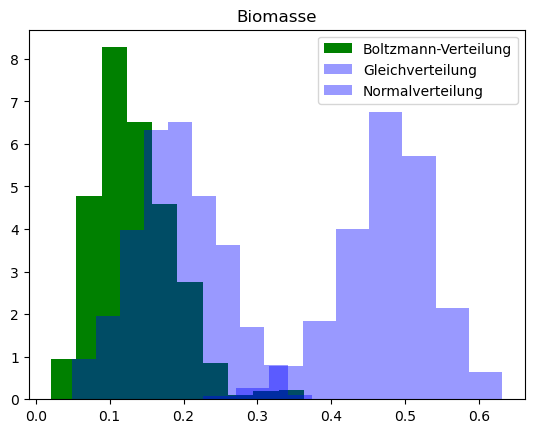

In [138]:
plt.title('Biomasse')
plt.hist(samples['boltzmann'][0, :, biomass_index], density = True, color = "green", label = "Boltzmann-Verteilung")
plt.hist(samples['uniform'][0, :, biomass_index], density = True, color = "blue", label = "Gleichverteilung", alpha = 0.4)
plt.hist(samples['normal'][0, :, biomass_index], density = True, color = "blue", label = "Normalverteilung", alpha = 0.4)

plt.legend(loc='upper right')

plt.show()

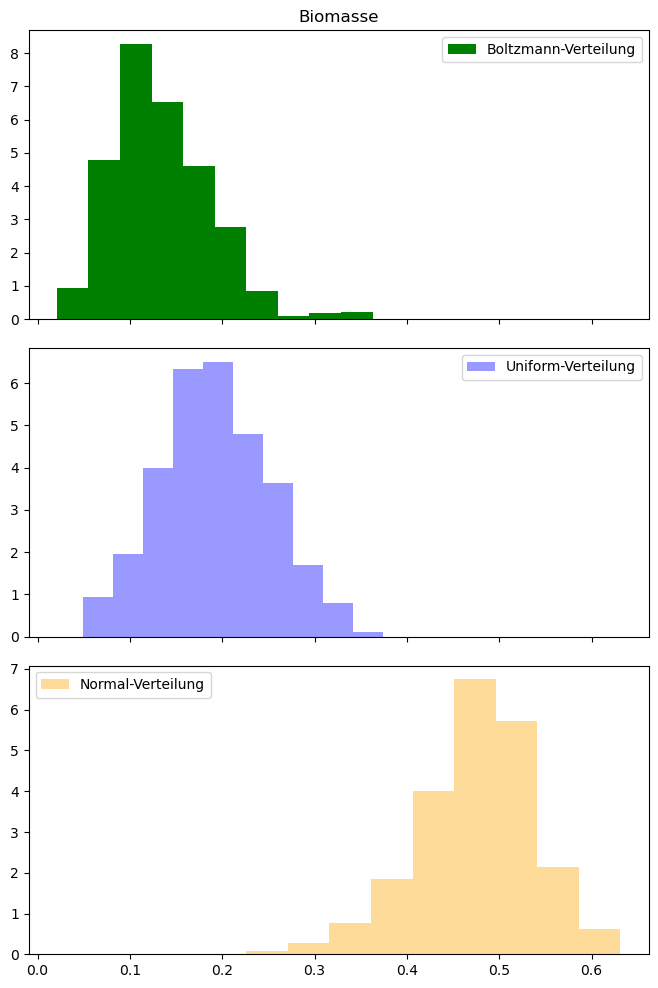

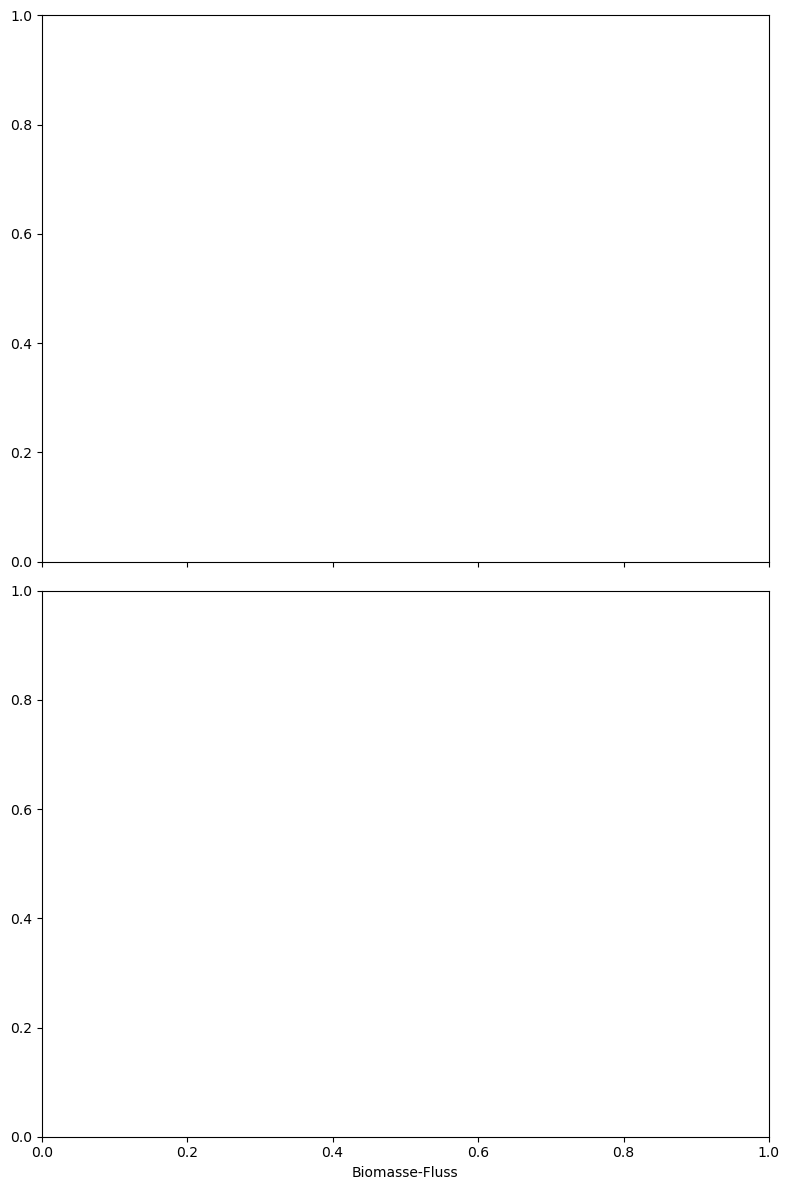

In [144]:
# Randdichten untereinander darstellen
# Subplots erstellen
fig, axs = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

plt.subplots_adjust(hspace=0.1)  # Abstand zwischen Subplots einstellen
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 12))
axs[0].hist(samples['boltzmann'][0, :, biomass_index], density = True, color = "green", label = "Boltzmann-Verteilung")
axs[0].set_title("Biomasse")

axs[1].hist(samples['uniform'][0, :, biomass_index], density = True, color = "blue", label = "Uniform-Verteilung", alpha = 0.4)

axs[2].hist(samples['normal'][0, :, biomass_index], density = True, color = "orange", label = "Normal-Verteilung", alpha = 0.4)

# Diagramme anzeigen
plt.xlabel('Biomasse-Fluss')

for ax in axs:
    ax.legend()
    
# Abstand zwischen Subplots anpassen
plt.tight_layout()
plt.show()

In [139]:
# Zu betrachtende Flüsse
lst_plot = ['EX_ac_e',
'EX_acgam_e',
'EX_ala_L_e',
'EX_arg_L_e',
'EX_asn_L_e',
'EX_asp_L_e',
'EX_cit_e',
'EX_co2_e',
'EX_cys_L_e',
'EX_etoh_e',
'EX_fe2_e',
'EX_for_e',
'EX_fru_e',
'EX_fum_e',
'EX_gal_e',
'EX_glc_e',
'EX_glcn_e',
'EX_gln_L_e',
'EX_glu_L_e',
'EX_gly_e',
'EX_glyc_e',
'EX_h2o_e',
'EX_his_L_e',
'EX_ile_L_e',
'EX_lac_D_e',
'EX_lac_L_e',
'EX_leu_L_e',
'EX_lys_L_e',
'EX_mal_L_e',
'EX_man_e',
'EX_met_L_e',
'EX_na1_e',
'EX_nh3_e',
'EX_no2_e',
'EX_no3_e',
'EX_o2_e',
'EX_orn_e',
'EX_phe_L_e',
'EX_ppi_e',
'EX_pnto_R_e',
'EX_pro_L_e',
'EX_pyr_e',
'EX_rib_D_e',
'EX_ser_L_e',
'EX_so3_e',
'EX_suc_e',
'EX_sucr_e',
'EX_thr_L_e',
'EX_tre_e',
'EX_trp_L_e',
'EX_tyr_L_e',
'EX_ura_e',
'EX_urea_e',
'EX_val_L_e',
'EX_xyl_D_e',
'EX_ncam_e',
'EX_btn_e',
'EX_ppa_e',
'pyk',
'rpe',
'mez']

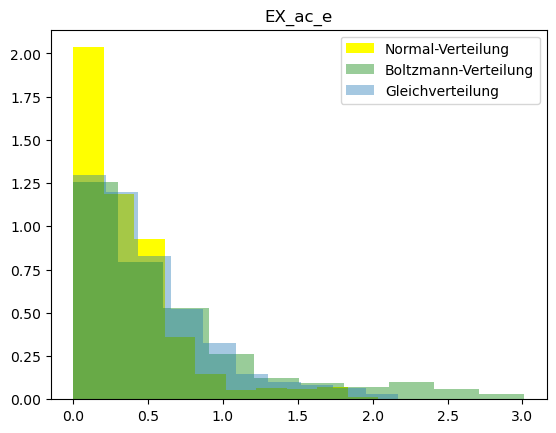

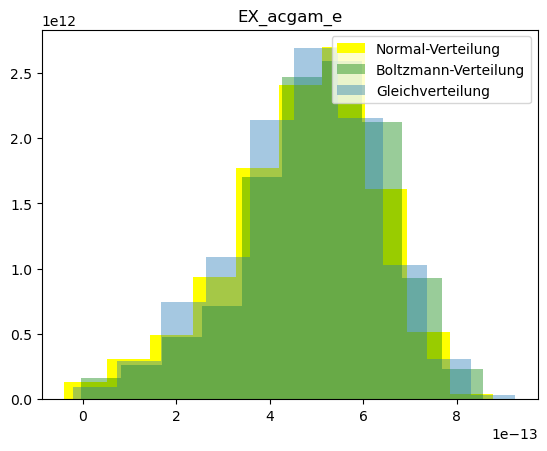

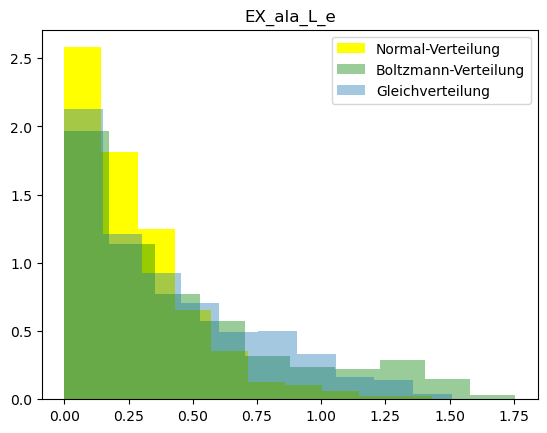

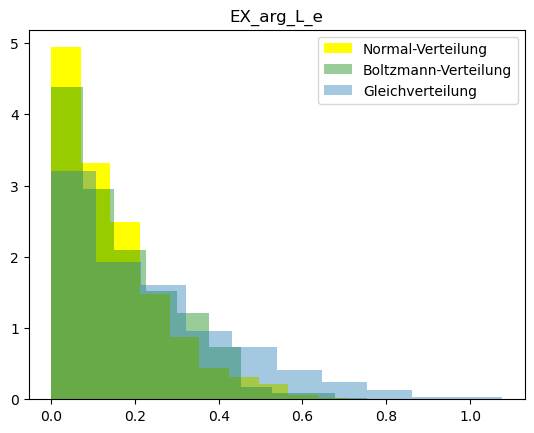

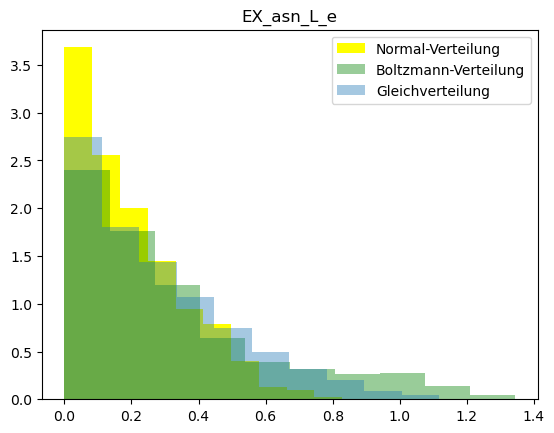

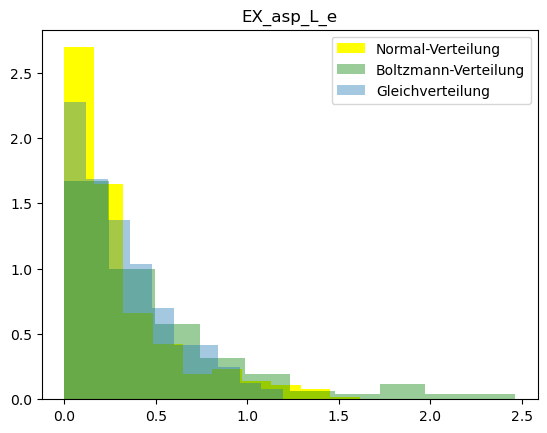

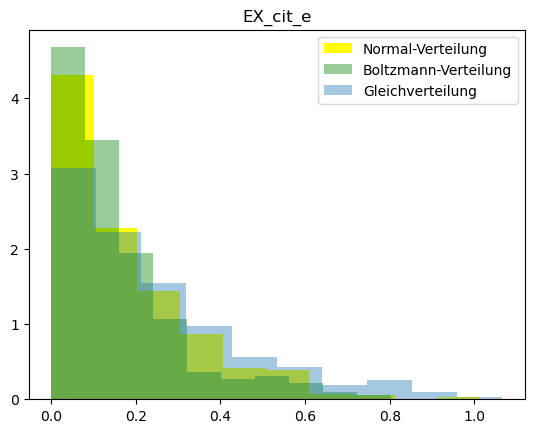

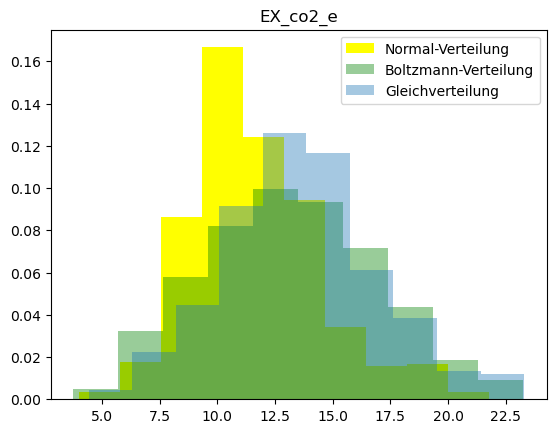

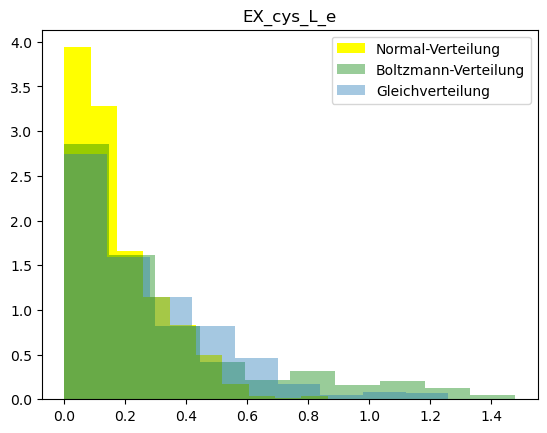

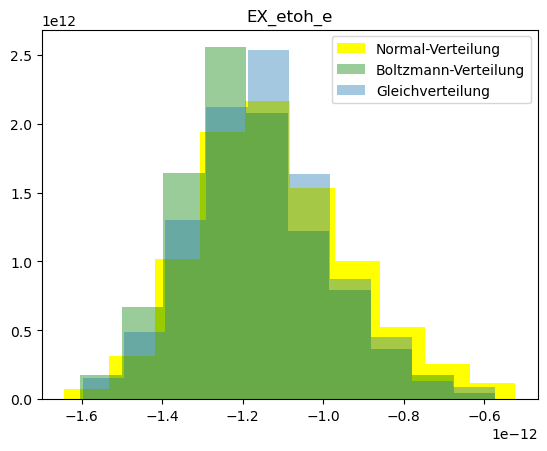

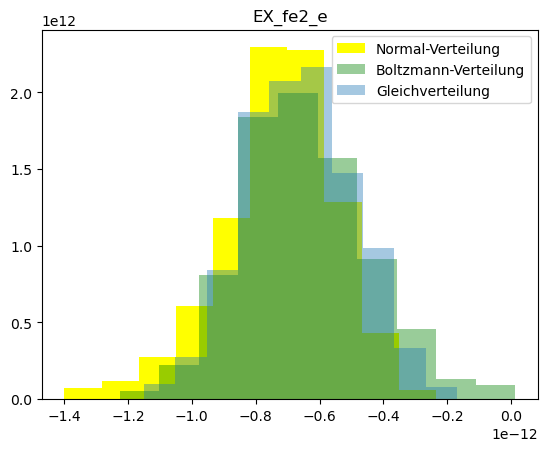

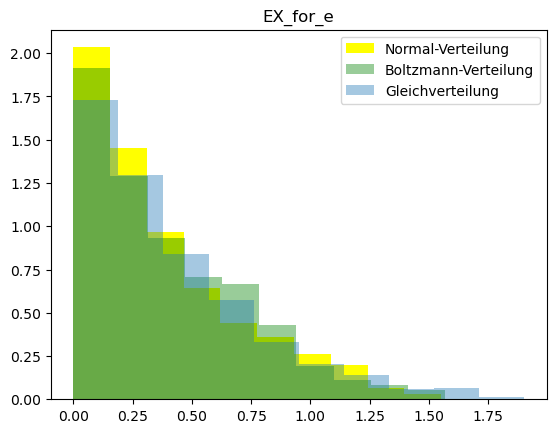

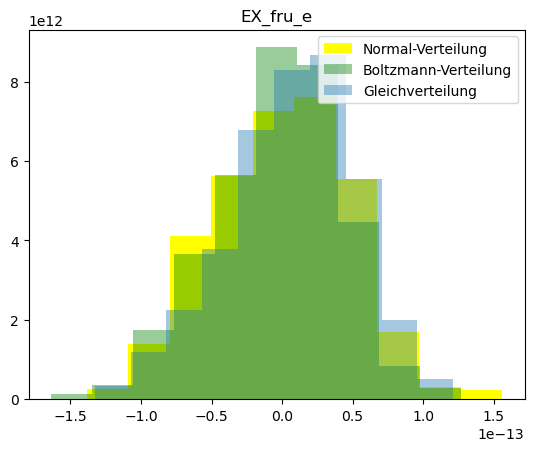

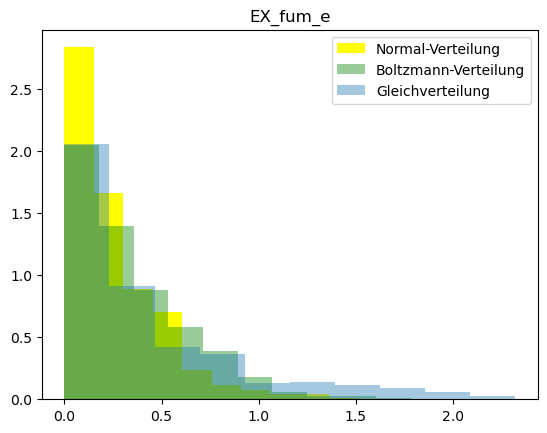

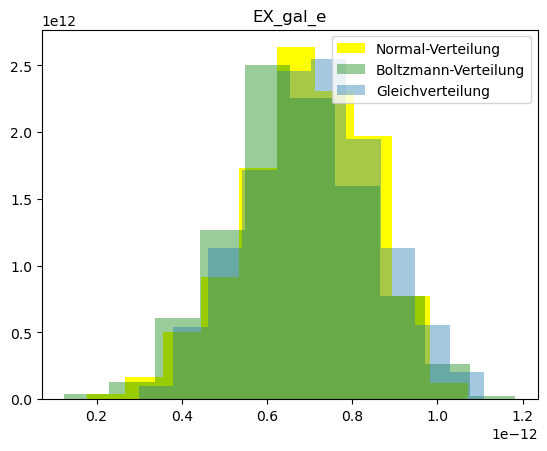

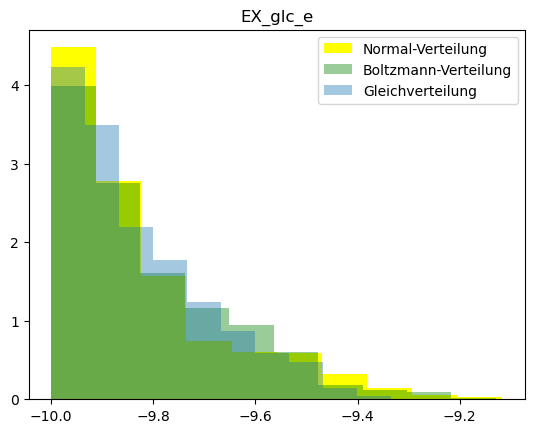

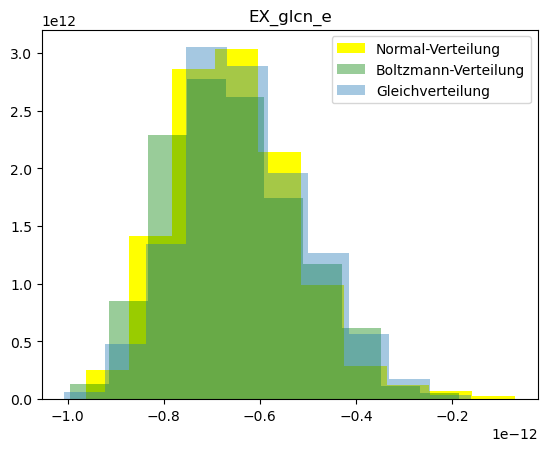

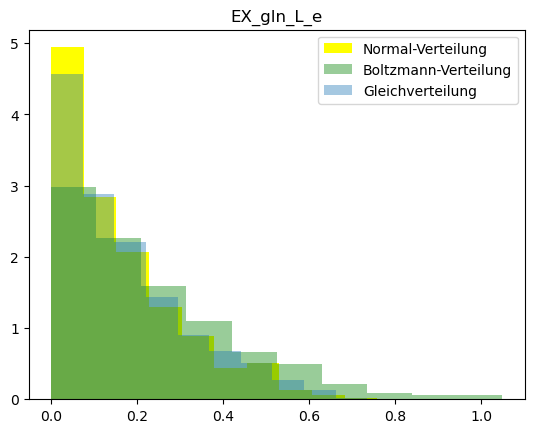

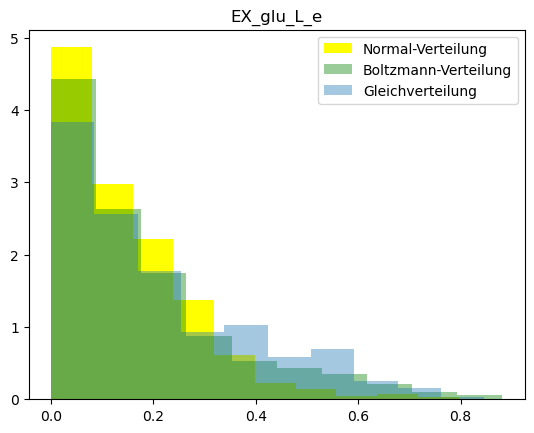

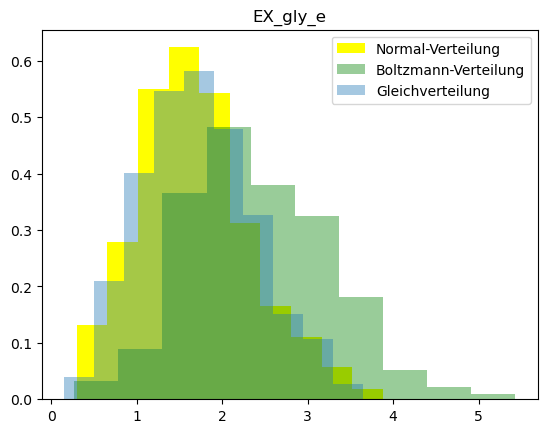

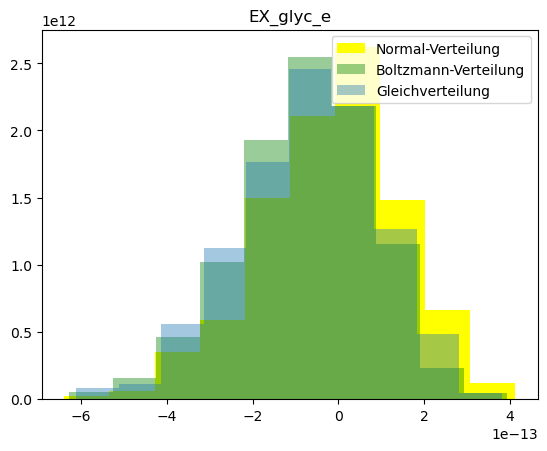

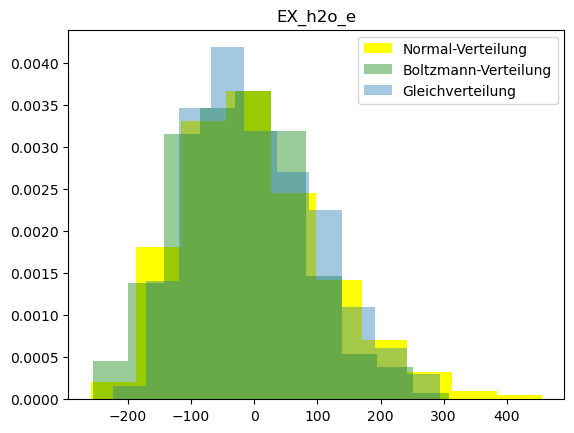

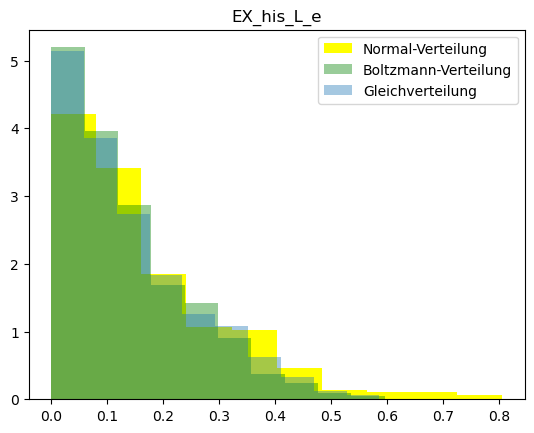

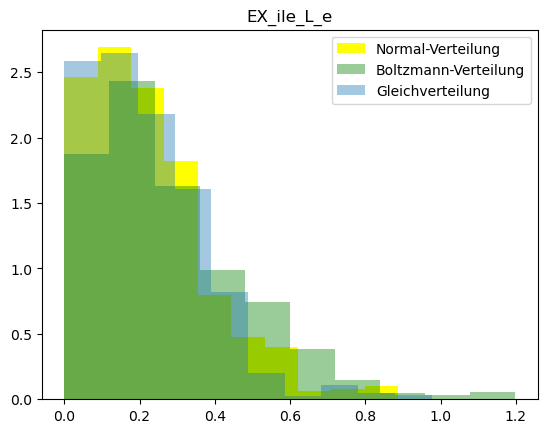

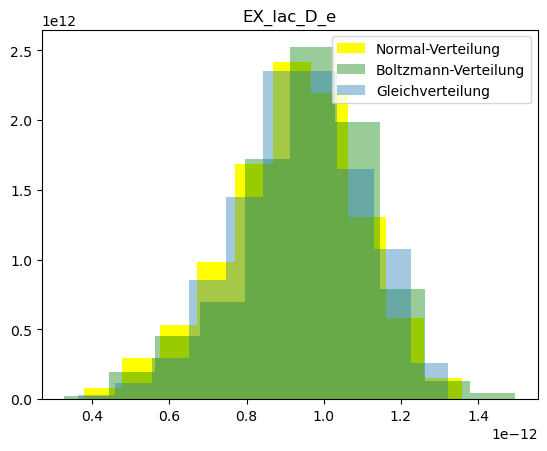

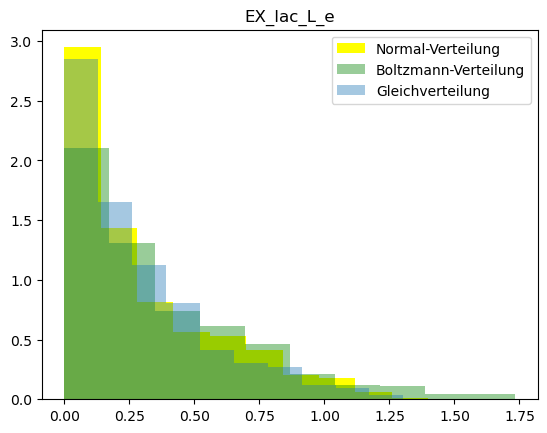

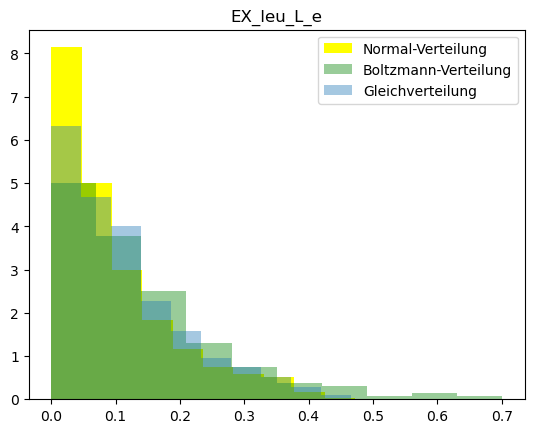

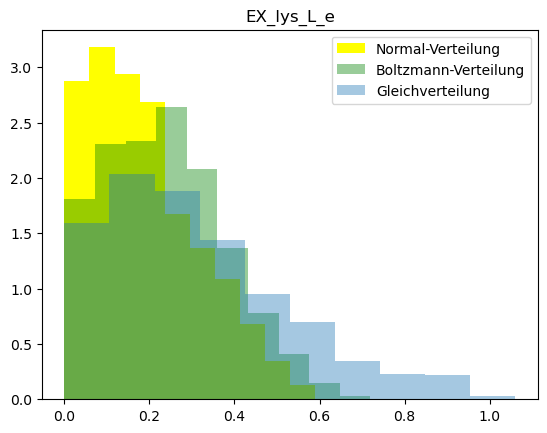

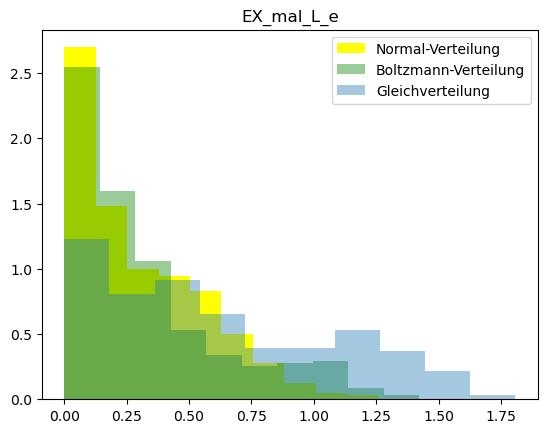

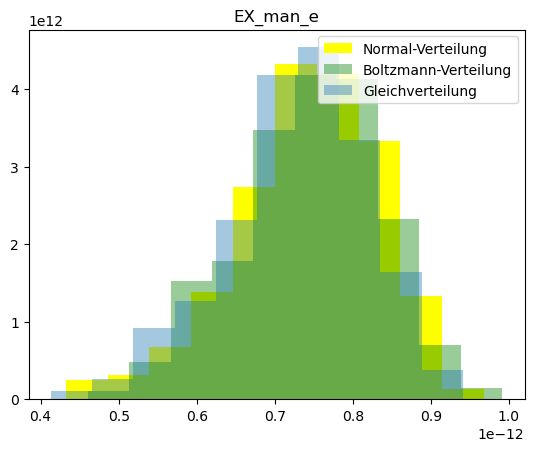

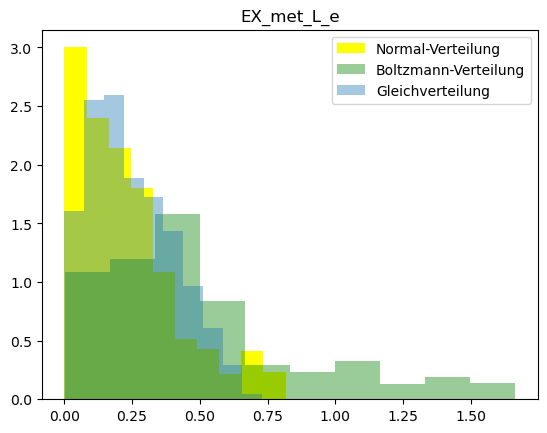

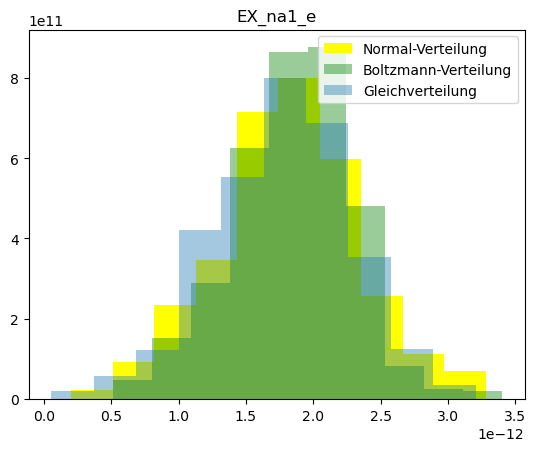

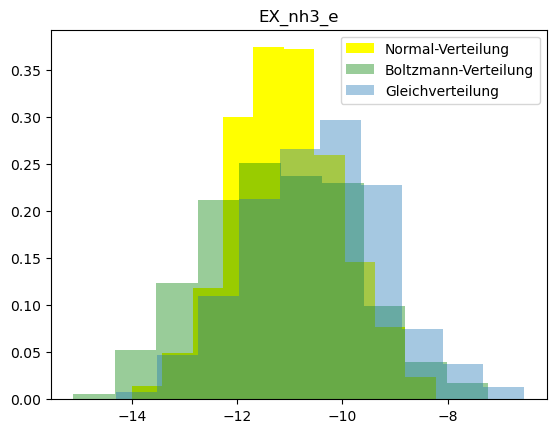

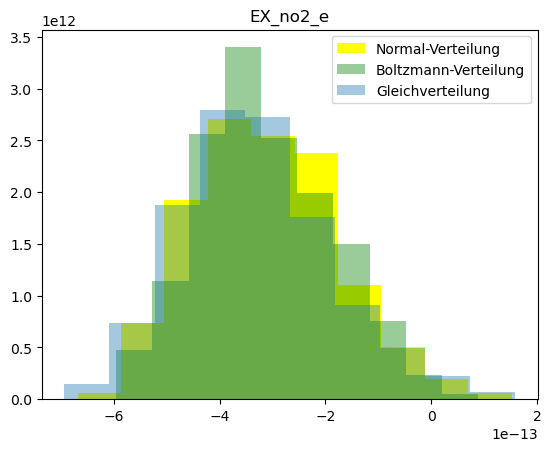

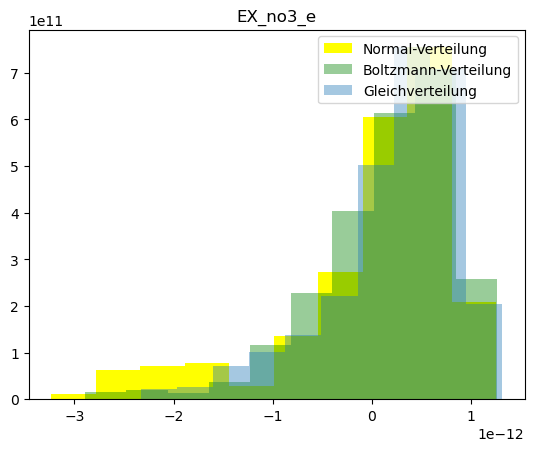

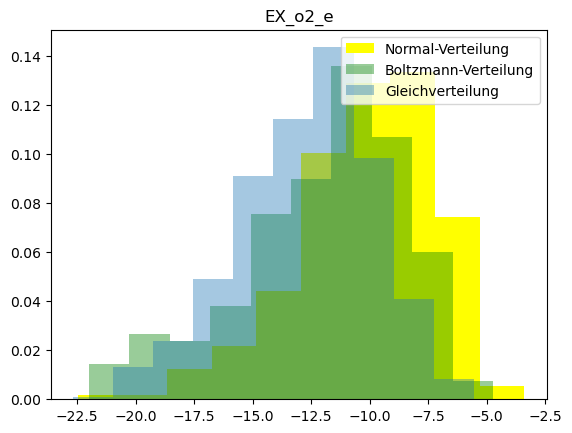

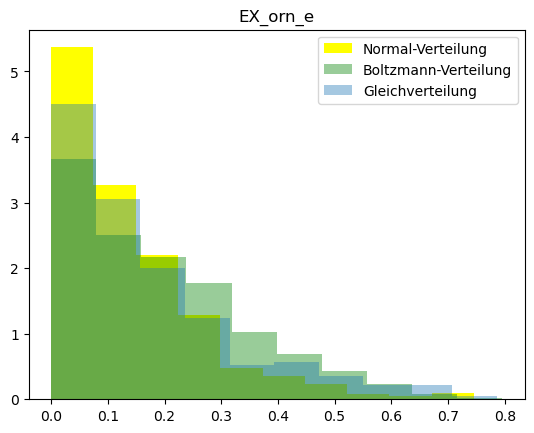

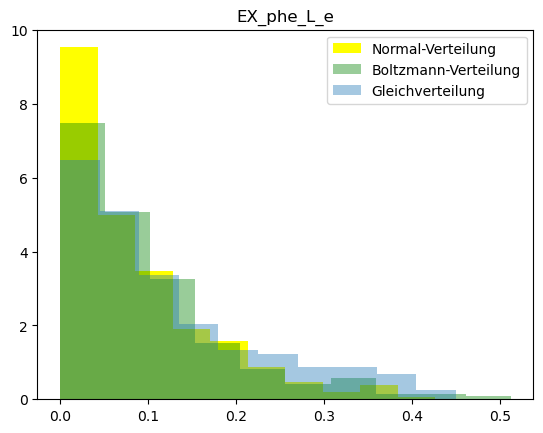

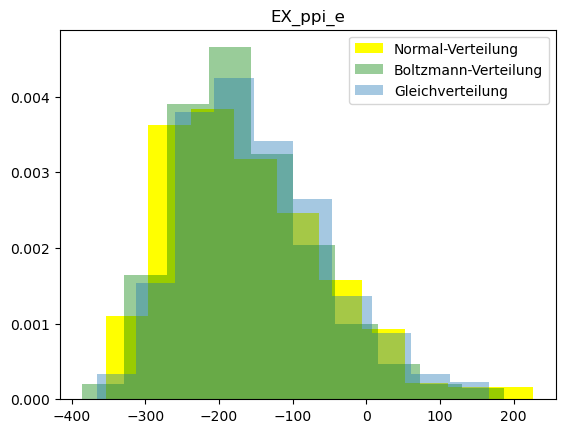

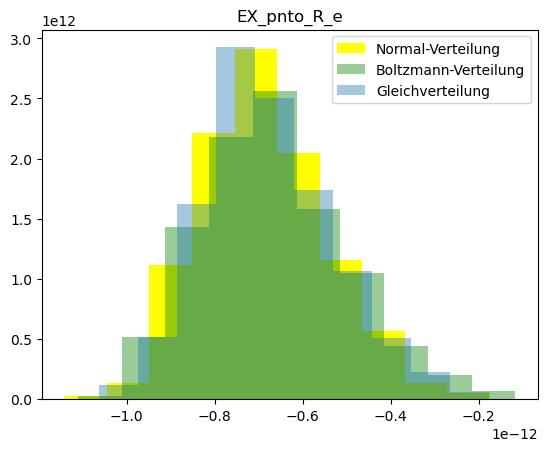

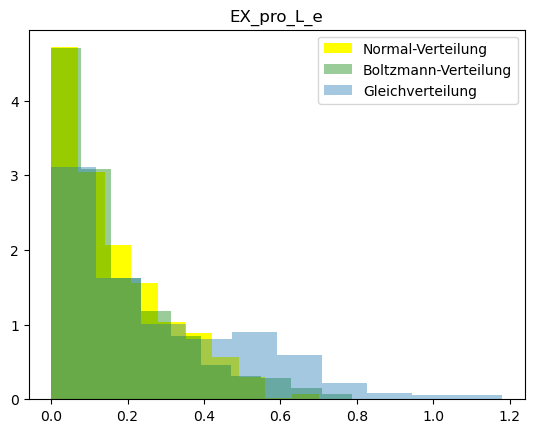

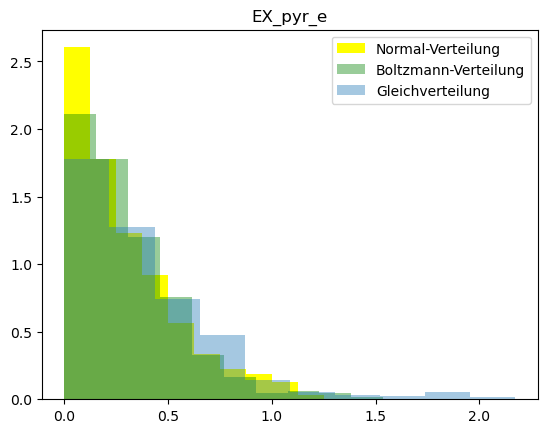

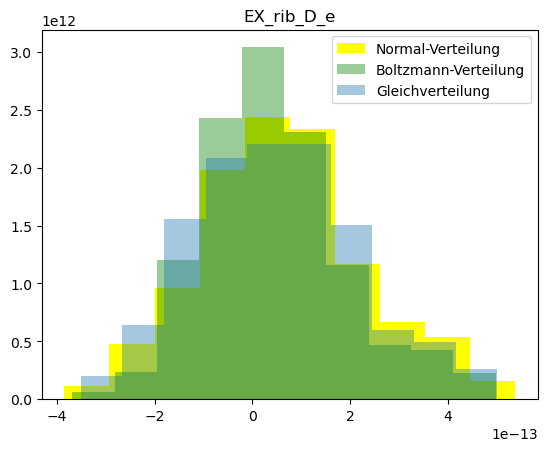

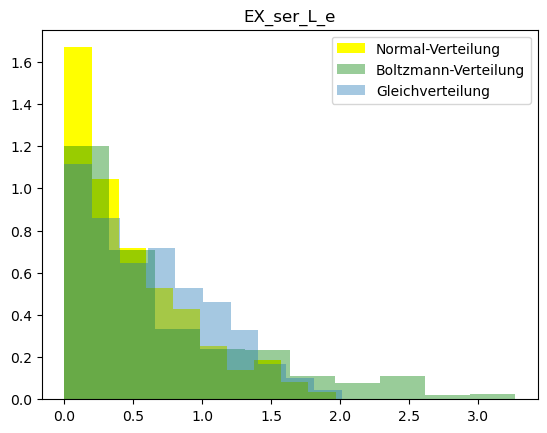

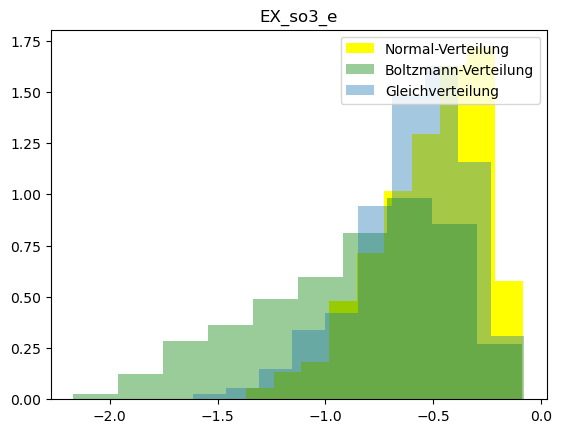

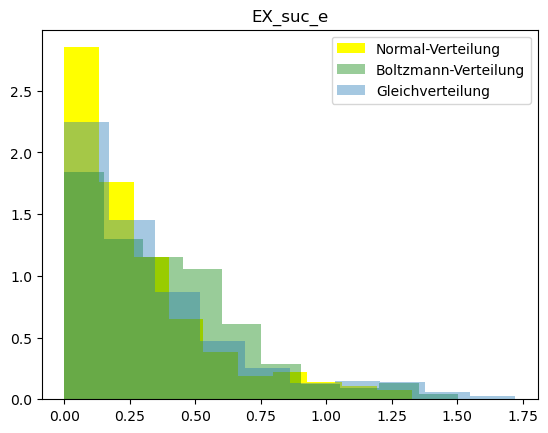

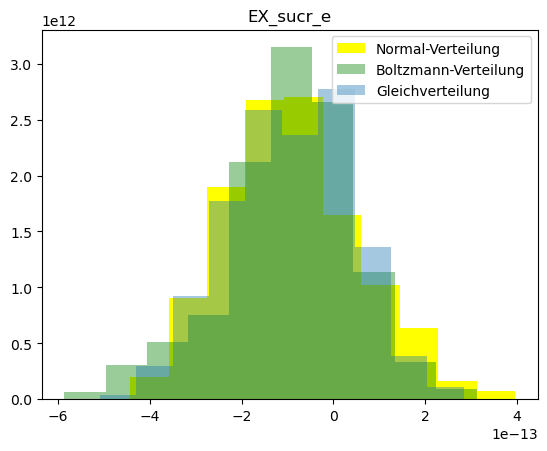

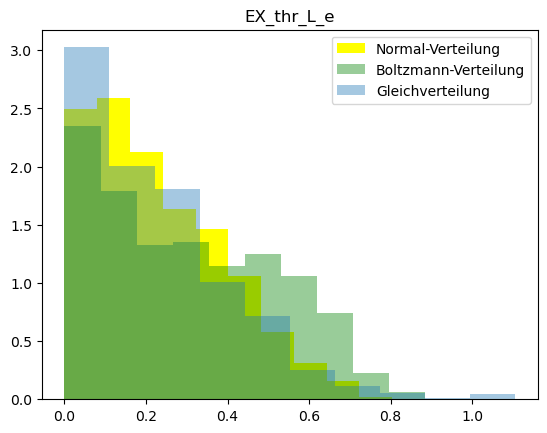

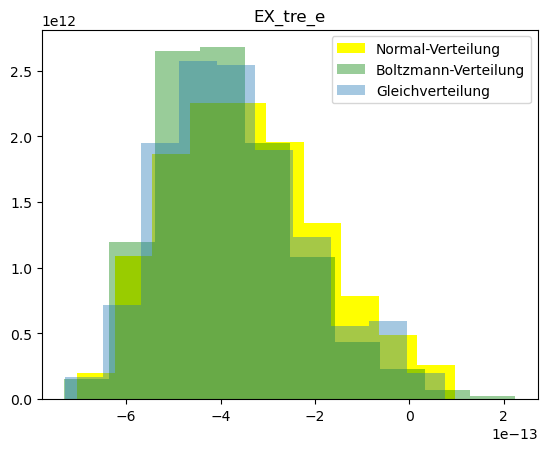

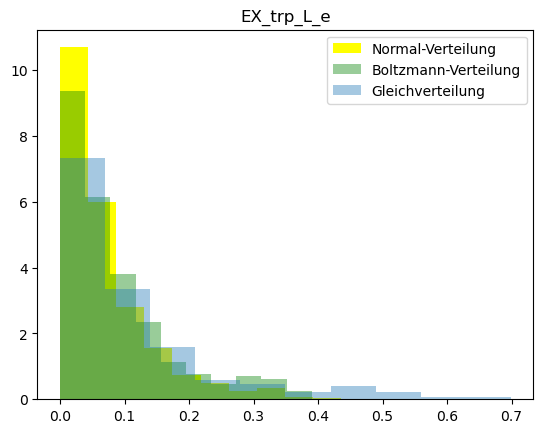

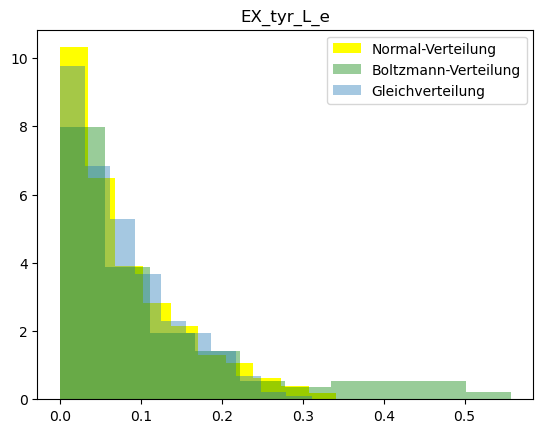

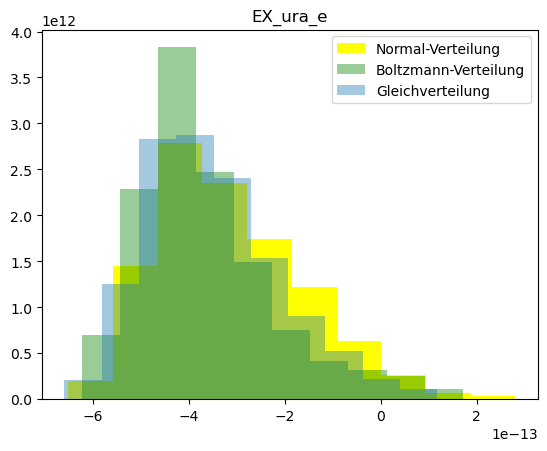

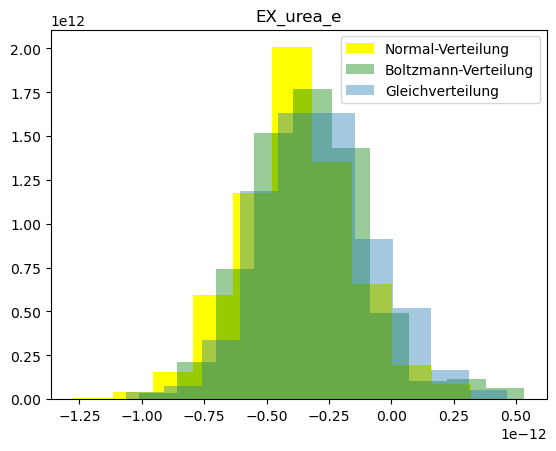

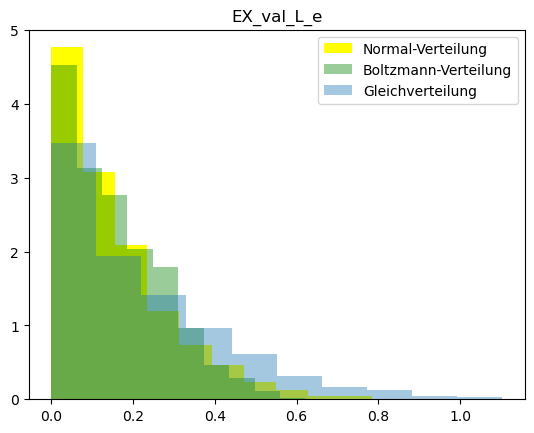

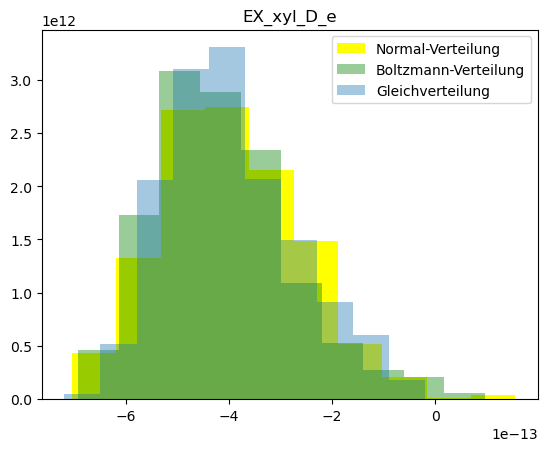

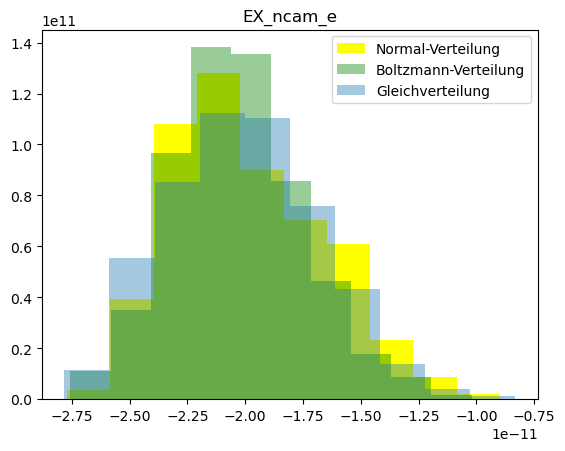

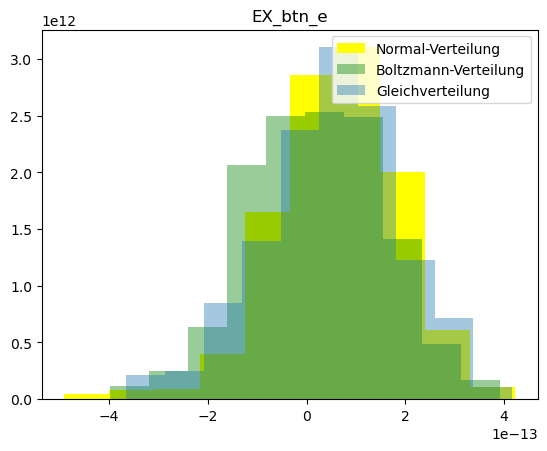

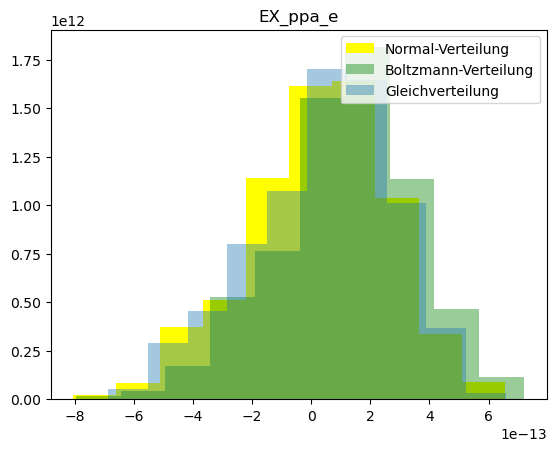

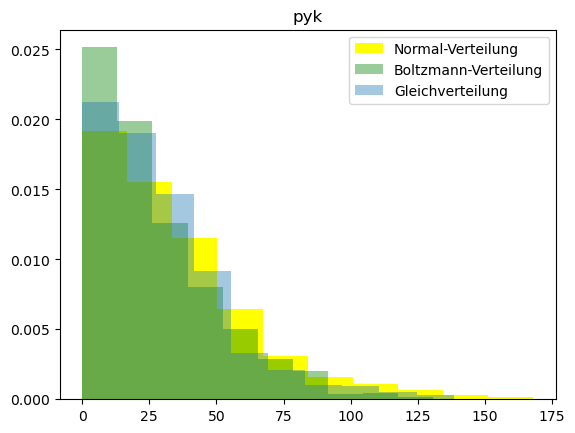

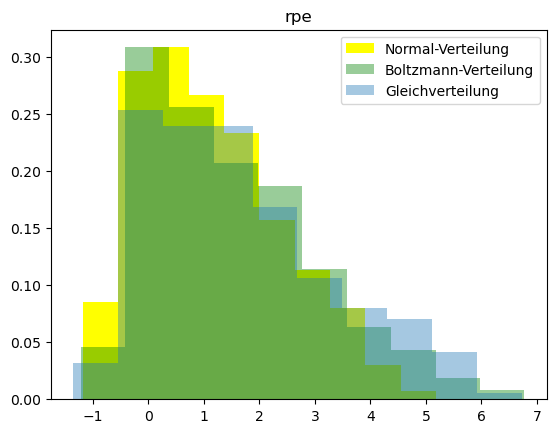

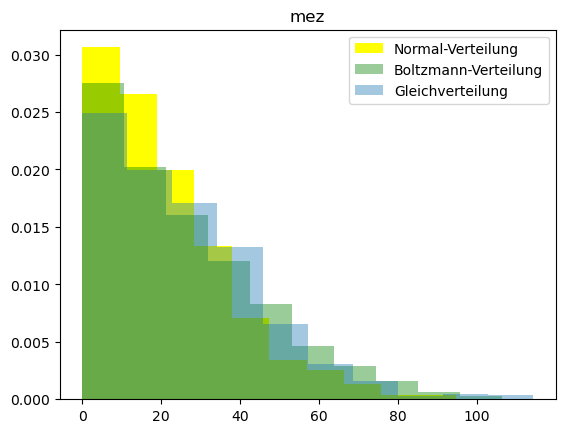

In [140]:
for i in lst_plot:
    ind = raw_polytope.A.columns.tolist().index(i)
    plt.title(i)
    plt.hist(samples['normal'][0, :, ind], density = True, color = "yellow", label = "Normal-Verteilung")
    plt.hist(samples['boltzmann'][0, :, ind], density = True, color = "green", label = "Boltzmann-Verteilung", alpha = 0.4)
    plt.hist(samples['uniform'][0, :, ind], density = True, label = "Gleichverteilung", alpha = 0.4)
    plt.legend(loc='upper right')

    plt.show()

Beispiel mit optimalem Transport - (noch) ohne Zusammenhang zu den Daten

In [ ]:
def cost_matrix(x, y):
    
    # Define the linear program
    n = len(x)
    m = len(y)
    c = np.zeros((n, m))

    for i in range(n):
        for j in range(m) :
            c[i, j] = (x[i] - y[j]) ** 2  # Quadratic cost matrix    
    return c

p = [0.2, 0.8]
q = [0.1, 0.4, 0.5]

# Example usage
x = [1, 2]
y = [3, 4, 10]


matrix = cost_matrix(x, y)
print(matrix)

emd = ot.emd2(p,q,matrix)
print(emd)

Statistische Test zum Vergleich der (Rand-)dichten

In [ ]:
# Eindimensionaler Kolmogorov-Smirnov-Test
# Beispiel-Daten für zwei Stichproben
sample1 = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
sample2 = np.array([0.15, 0.25, 0.35, 0.45, 0.55])

# Führen Sie den KS-Test durch
ks_statistic, p_value = stats.ks_2samp(sample1, sample2)

# Interpretation des Ergebnisses
alpha = 0.05  # Signifikanzniveau
if p_value < alpha:
    print("Die beiden Stichproben stammen wahrscheinlich nicht aus derselben Verteilung.")
else:
    print("Es gibt keine ausreichenden Beweise, um zu sagen, dass die Stichproben aus unterschiedlichen Verteilungen stammen.")


Im hochdimensionalen gibt es verschiedene Tests, die zum Vergleich der Dichten verwendet werden können. Dazu zählen:

Multivariate Kolmogorov-Smirnov-Test: Dies ist eine Erweiterung des eindimensionalen KS-Tests auf höherdimensionale Daten. Es wird verwendet, um festzustellen, ob zwei Stichproben aus denselben multivariaten Verteilungen stammen.

 Anderson-Darling-Test: Der Anderson-Darling-Test kann für die Prüfung der Anpassung von Daten an eine bestimmte multivariate Verteilung verwendet werden. Es bewertet, wie gut die Daten zu einer vorgegebenen Verteilung passen.

Multivariate Shapiro-Wilk-Test: Dies ist eine Erweiterung des Shapiro-Wilk-Tests auf höherdimensionale Daten. Es prüft die Normalverteilung von Daten in mehreren Dimensionen.

 Multivariates Kolmogorov-Smirnov-Test für zwei Stichproben: Ähnlich wie der univariate KS-Test, aber für mehrdimensionale Daten. Es prüft, ob zwei Stichproben aus denselben multivariaten Verteilungen stammen.

Hotelling's T^2-Test: Dieser Test wird verwendet, um festzustellen, ob die Mittelwerte von zwei Stichproben in mehreren Dimensionen signifikant unterschiedlich sind. Er ist nützlich, wenn Sie die Mittelwerte von multivariaten Daten vergleichen möchten.

 
hochdimensionaler Kolmogorov-Smirnov-Test (Fasano, 1987) ist nicht in Python implementiert.